In [1]:
import os
import torch
from accelerate import Accelerator

from llama2_Model import  llama2_7b_Model_peft
from pap_Dataloader import pap_Dataloader
from evaluation import get_accuracy, get_precision_recall

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
! nvidia-smi

Mon Jan 22 12:17:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.01              Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P0              12W /  78W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get model and dataloader

In [3]:
def get_filepath(name,classnum_name,file_name):
    '''
    param name: name of the dataset, pep-3k or pap
    param classnum_name: for pap dataset, binary or multiclass
    param file_name: dev, test, train
    return: the str of apath of the file
    '''
    current_dir =os.path.realpath(".")
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    if name=='pap':
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split-filtered',classnum_name,file_name+'.csv'))
    else:
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split',classnum_name,file_name+'.csv'))
    print(filepath)
    return filepath


In [4]:
# Model from Hugging Face hub
base_model= "meta-llama/Llama-2-7b-hf"

filepath1=get_filepath('pap','binary','train')
filepath2=get_filepath('pap','binary','dev')
filepath3=get_filepath('pap','binary','test')


/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/train.csv
/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/dev.csv
/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/test.csv


In [5]:
llama_model = llama2_7b_Model_peft(base_model)
tokenizer = llama_model.tokenizer

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original number of parameters: 6607351808
LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (p

In [6]:
train_dataloader_object=pap_Dataloader(filepath1,tokenizer,3)
eval_dataloader_object=pap_Dataloader(filepath2,tokenizer,'defalut')
test_dataloader_object=pap_Dataloader(filepath3,tokenizer,'defalut')

Dataset({
    features: ['text', 'labels'],
    num_rows: 1386
})


Map: 100%|██████████| 1386/1386 [00:00<00:00, 31880.28 examples/s]


Dataset({
    features: ['text', 'labels'],
    num_rows: 173
})


Map: 100%|██████████| 173/173 [00:00<00:00, 11944.67 examples/s]


Dataset({
    features: ['text', 'labels'],
    num_rows: 174
})


Map: 100%|██████████| 174/174 [00:00<00:00, 11954.48 examples/s]


In [7]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
from transformers import get_scheduler

optimizer = AdamW(llama_model.model.parameters(), lr=1e-4 )#5e-5)
loss_fn = nn.CrossEntropyLoss()

accelerator = Accelerator()
train_dataloader, eval_dataloader,test_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader_object.dataloader, eval_dataloader_object.dataloader, test_dataloader_object.dataloader , llama_model.model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader_object.dataset)

#learning rate adjustment:
lr_scheduler = get_scheduler( 
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Check original model with test data

In [8]:
def do_inference(dataloader):
    model.eval()
    with torch.no_grad():
        for labels,text in dataloader:
            logits = model(**text).logits
            the_labels=labels
            get_accuracy(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag='false',flag2='print')

In [9]:
do_inference(test_dataloader)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.615
---positive is plausible
Precision: 0.868
Recall: 0.347
F-score: 0.496
---positive is implausible
Precision: 0.544
Recall: 0.937
F-score: 0.688


### Train

In [10]:
loss_list=[]
accuracy_list=[]
loss_sum=0
accuracy_sum=0

In [11]:
print(num_epochs)
print(len(train_dataloader))
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)
print(num_training_steps/20)
# print(int(num_training_steps/30))
for thelabels,text in train_dataloader:
    print('thelabels:',thelabels)
    print('text:',text)
    break

3
462
1386
69.3
thelabels: tensor([1, 1, 1], device='cuda:0')
text: {'input_ids': tensor([[    1,  2706,  2011,   764, 29879, 27450,   291,     2,     2,     2,
             2,     2,     2],
        [    1,  2278,  3990,  1078, 21149,     2,     2,     2,     2,     2,
             2,     2,     2],
        [    1, 24894, 29467,  7213,  4637,  3974,  1003, 29882,   357,     2,
             2,     2,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], device='cuda:0')}


In [12]:
# train
progress_bar = tqdm(range(int(num_training_steps/20)))

flag=0
for epoch in range(num_epochs):
    for thelabels,text in train_dataloader:
        model.train()
        outputs = model(**text)
        logits = outputs.logits
        loss = loss_fn(logits.squeeze(), thelabels)
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        flag+=1

        loss_sum += int(loss.item())
        a=get_accuracy(logits, thelabels)
        accuracy_sum+=a

        if flag%20==0:
            print(flag,'loss:,',loss_sum/flag, 'accuarcy:',accuracy_sum/flag)
            loss_list.append(loss_sum/flag)
            accuracy_list.append(accuracy_sum/flag)
            progress_bar.update(1)

  0%|          | 0/69 [00:00<?, ?it/s]/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
  1%|▏         | 1/69 [00:50<56:40, 50.01s/it]

20 loss:, 0.75 accuarcy: 0.6


  3%|▎         | 2/69 [01:40<56:07, 50.26s/it]

40 loss:, 0.6 accuarcy: 0.625


  4%|▍         | 3/69 [02:30<55:17, 50.27s/it]

60 loss:, 0.48333333333333334 accuarcy: 0.6666666666666666


  6%|▌         | 4/69 [03:20<54:04, 49.92s/it]

80 loss:, 0.4625 accuarcy: 0.6624999999999998


  7%|▋         | 5/69 [04:10<53:14, 49.91s/it]

100 loss:, 0.48 accuarcy: 0.6666666666666664


  9%|▊         | 6/69 [04:59<52:19, 49.84s/it]

120 loss:, 0.475 accuarcy: 0.6555555555555554


 10%|█         | 7/69 [05:49<51:24, 49.75s/it]

140 loss:, 0.4142857142857143 accuarcy: 0.6690476190476192


 12%|█▏        | 8/69 [06:38<50:33, 49.73s/it]

160 loss:, 0.3875 accuarcy: 0.679166666666667


 13%|█▎        | 9/69 [07:28<49:48, 49.81s/it]

180 loss:, 0.37777777777777777 accuarcy: 0.6851851851851856


 14%|█▍        | 10/69 [08:18<49:01, 49.86s/it]

200 loss:, 0.34 accuarcy: 0.7016666666666669


 16%|█▌        | 11/69 [09:08<48:04, 49.73s/it]

220 loss:, 0.33181818181818185 accuarcy: 0.7045454545454547


 17%|█▋        | 12/69 [09:57<47:12, 49.69s/it]

240 loss:, 0.32083333333333336 accuarcy: 0.7125


 19%|█▉        | 13/69 [10:47<46:26, 49.76s/it]

260 loss:, 0.3076923076923077 accuarcy: 0.7205128205128204


 20%|██        | 14/69 [11:37<45:36, 49.75s/it]

280 loss:, 0.29642857142857143 accuarcy: 0.7285714285714283


 22%|██▏       | 15/69 [12:27<44:45, 49.73s/it]

300 loss:, 0.29333333333333333 accuarcy: 0.7322222222222217


 23%|██▎       | 16/69 [13:17<44:02, 49.87s/it]

320 loss:, 0.284375 accuarcy: 0.7406249999999994


 25%|██▍       | 17/69 [14:07<43:20, 50.01s/it]

340 loss:, 0.2735294117647059 accuarcy: 0.7441176470588228


 26%|██▌       | 18/69 [14:57<42:23, 49.88s/it]

360 loss:, 0.2611111111111111 accuarcy: 0.7509259259259254


 28%|██▊       | 19/69 [15:46<41:28, 49.77s/it]

380 loss:, 0.25263157894736843 accuarcy: 0.7552631578947367


 29%|██▉       | 20/69 [16:36<40:43, 49.86s/it]

400 loss:, 0.2475 accuarcy: 0.7600000000000001


 30%|███       | 21/69 [17:27<39:58, 49.97s/it]

420 loss:, 0.23809523809523808 accuarcy: 0.7658730158730164


 32%|███▏      | 22/69 [18:16<39:06, 49.92s/it]

440 loss:, 0.22727272727272727 accuarcy: 0.7734848484848491


 33%|███▎      | 23/69 [19:06<38:09, 49.78s/it]

460 loss:, 0.22391304347826088 accuarcy: 0.7775362318840587


 35%|███▍      | 24/69 [19:56<37:23, 49.85s/it]

480 loss:, 0.21458333333333332 accuarcy: 0.781250000000001


 36%|███▌      | 25/69 [20:45<36:28, 49.75s/it]

500 loss:, 0.206 accuarcy: 0.788000000000001


 38%|███▊      | 26/69 [21:35<35:33, 49.61s/it]

520 loss:, 0.19807692307692307 accuarcy: 0.7948717948717959


 39%|███▉      | 27/69 [22:25<34:49, 49.76s/it]

540 loss:, 0.19074074074074074 accuarcy: 0.7987654320987667


 41%|████      | 28/69 [23:15<34:05, 49.89s/it]

560 loss:, 0.18392857142857144 accuarcy: 0.8053571428571441


 42%|████▏     | 29/69 [24:05<33:13, 49.83s/it]

580 loss:, 0.17758620689655172 accuarcy: 0.8103448275862082


 43%|████▎     | 30/69 [24:54<32:21, 49.77s/it]

600 loss:, 0.17333333333333334 accuarcy: 0.8138888888888903


 45%|████▍     | 31/69 [25:45<31:35, 49.87s/it]

620 loss:, 0.16774193548387098 accuarcy: 0.8177419354838724


 46%|████▋     | 32/69 [26:34<30:42, 49.79s/it]

640 loss:, 0.1671875 accuarcy: 0.8187500000000012


 48%|████▊     | 33/69 [27:24<29:51, 49.75s/it]

660 loss:, 0.16363636363636364 accuarcy: 0.8222222222222232


 49%|████▉     | 34/69 [28:15<29:13, 50.09s/it]

680 loss:, 0.1588235294117647 accuarcy: 0.826470588235295


 51%|█████     | 35/69 [29:06<28:33, 50.40s/it]

700 loss:, 0.15571428571428572 accuarcy: 0.8285714285714292


 52%|█████▏    | 36/69 [29:57<27:52, 50.68s/it]

720 loss:, 0.15138888888888888 accuarcy: 0.8305555555555558


 54%|█████▎    | 37/69 [30:48<27:03, 50.75s/it]

740 loss:, 0.1472972972972973 accuarcy: 0.8337837837837839


 55%|█████▌    | 38/69 [31:40<26:20, 50.99s/it]

760 loss:, 0.14605263157894738 accuarcy: 0.8350877192982455


 57%|█████▋    | 39/69 [32:31<25:31, 51.06s/it]

780 loss:, 0.1423076923076923 accuarcy: 0.8388888888888888


 58%|█████▊    | 40/69 [33:21<24:36, 50.91s/it]

800 loss:, 0.13875 accuarcy: 0.8404166666666663


 59%|█████▉    | 41/69 [34:11<23:38, 50.65s/it]

820 loss:, 0.1353658536585366 accuarcy: 0.8434959349593492


 61%|██████    | 42/69 [35:02<22:46, 50.61s/it]

840 loss:, 0.13690476190476192 accuarcy: 0.8444444444444438


 62%|██████▏   | 43/69 [35:52<21:52, 50.49s/it]

860 loss:, 0.13488372093023257 accuarcy: 0.8468992248062008


 64%|██████▍   | 44/69 [36:42<20:59, 50.39s/it]

880 loss:, 0.13295454545454546 accuarcy: 0.8484848484848475


 65%|██████▌   | 45/69 [37:33<20:14, 50.59s/it]

900 loss:, 0.13111111111111112 accuarcy: 0.849259259259258


 67%|██████▋   | 46/69 [38:24<19:24, 50.64s/it]

920 loss:, 0.13152173913043477 accuarcy: 0.8499999999999985


 68%|██████▊   | 47/69 [39:15<18:32, 50.57s/it]

940 loss:, 0.12872340425531914 accuarcy: 0.8524822695035446


 70%|██████▉   | 48/69 [40:05<17:39, 50.47s/it]

960 loss:, 0.12604166666666666 accuarcy: 0.8555555555555541


 71%|███████   | 49/69 [40:56<16:51, 50.58s/it]

980 loss:, 0.12346938775510204 accuarcy: 0.8585034013605427


 72%|███████▏  | 50/69 [41:46<16:00, 50.58s/it]

1000 loss:, 0.121 accuarcy: 0.8609999999999985


 74%|███████▍  | 51/69 [42:37<15:11, 50.64s/it]

1020 loss:, 0.11862745098039215 accuarcy: 0.863398692810456


 75%|███████▌  | 52/69 [43:28<14:23, 50.79s/it]

1040 loss:, 0.11634615384615385 accuarcy: 0.8653846153846139


 77%|███████▋  | 53/69 [44:18<13:30, 50.66s/it]

1060 loss:, 0.11415094339622642 accuarcy: 0.8669811320754701


 78%|███████▊  | 54/69 [45:09<12:37, 50.52s/it]

1080 loss:, 0.11296296296296296 accuarcy: 0.8691358024691341


 80%|███████▉  | 55/69 [45:59<11:45, 50.41s/it]

1100 loss:, 0.11181818181818182 accuarcy: 0.8712121212121196


 81%|████████  | 56/69 [46:50<10:57, 50.55s/it]

1120 loss:, 0.10982142857142857 accuarcy: 0.873214285714284


 83%|████████▎ | 57/69 [47:40<10:05, 50.47s/it]

1140 loss:, 0.10789473684210527 accuarcy: 0.8754385964912265


 84%|████████▍ | 58/69 [48:30<09:12, 50.27s/it]

1160 loss:, 0.1060344827586207 accuarcy: 0.8775862068965502


 86%|████████▌ | 59/69 [49:20<08:22, 50.22s/it]

1180 loss:, 0.10423728813559321 accuarcy: 0.879661016949151


 87%|████████▋ | 60/69 [50:10<07:30, 50.11s/it]

1200 loss:, 0.1025 accuarcy: 0.8813888888888874


 88%|████████▊ | 61/69 [51:00<06:41, 50.20s/it]

1220 loss:, 0.10081967213114754 accuarcy: 0.8833333333333319


 90%|████████▉ | 62/69 [51:50<05:51, 50.15s/it]

1240 loss:, 0.09919354838709678 accuarcy: 0.8852150537634395


 91%|█████████▏| 63/69 [52:40<05:01, 50.18s/it]

1260 loss:, 0.09761904761904762 accuarcy: 0.8862433862433851


 93%|█████████▎| 64/69 [53:31<04:11, 50.26s/it]

1280 loss:, 0.09609375 accuarcy: 0.8880208333333321


 94%|█████████▍| 65/69 [54:21<03:20, 50.14s/it]

1300 loss:, 0.09461538461538462 accuarcy: 0.8894871794871784


 96%|█████████▌| 66/69 [55:10<02:29, 49.97s/it]

1320 loss:, 0.09318181818181819 accuarcy: 0.8906565656565647


 97%|█████████▋| 67/69 [56:00<01:39, 49.92s/it]

1340 loss:, 0.09179104477611941 accuarcy: 0.8922885572139294


 99%|█████████▊| 68/69 [56:49<00:49, 49.70s/it]

1360 loss:, 0.09044117647058823 accuarcy: 0.8938725490196069


100%|██████████| 69/69 [57:39<00:00, 49.62s/it]

1380 loss:, 0.0891304347826087 accuarcy: 0.895169082125603


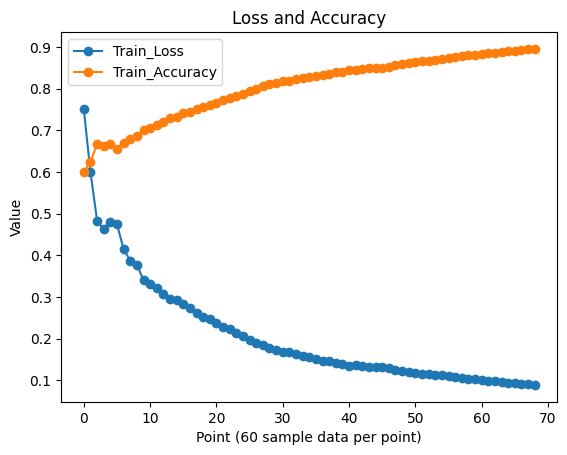

In [13]:
# print(loss_list)
# print(accuracy_list)

import matplotlib.pyplot as plt

# Plotting the data
plt.plot(loss_list, label='Train_Loss', marker='o')
plt.plot(accuracy_list, label='Train_Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Point (60 sample data per point)')
plt.ylabel('Value')
plt.title('Loss and Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [14]:
do_inference(test_dataloader)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.868
---positive is plausible
Precision: 0.986
Recall: 0.768
F-score: 0.864
---positive is implausible
Precision: 0.780
Recall: 0.987
F-score: 0.872


### for wrong prediction analysis, save the results to a file:

In [15]:
import numpy as np
def do_inference_analysis(dataloader):
    model.eval()
    text_list=[]
    with torch.no_grad():
        for labels,text in dataloader:
            text_ids=text['input_ids']
            for j in range(len(text_ids)):
                the_text=tokenizer.decode(text_ids[j], skip_special_tokens=True)
                text_list.append(the_text)
            logits = model(**text).logits
            the_labels=labels
            get_accuracy(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag='false',flag2='print')
            preds_up=logits.detach().cpu().numpy()
            preds = np.array([ i.argmax() for i in preds_up ])
            the_labels = np.array(the_labels.cpu())
    return text_list, preds,the_labels

In [16]:
text_list, preds,the_labels = do_inference_analysis(test_dataloader)

Accuracy: 0.868
---positive is plausible
Precision: 0.986
Recall: 0.768
F-score: 0.864
---positive is implausible
Precision: 0.780
Recall: 0.987
F-score: 0.872


In [17]:
text_list_pap=text_list
dict_pap={}
for i in range(len(text_list)):
    the_text=text_list_pap[i]
    dict_pap[the_text]={'preds':preds[i],'original_labels':the_labels[i]}
with open('result_analysis/pap_preds_filter.txt', 'w') as file:
    file.write(str(dict_pap))

In [18]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(in_features=4096, out_feat

In [22]:
text_list, preds,the_labels = do_inference_analysis(eval_dataloader)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.879
---positive is plausible
Precision: 0.867
Recall: 0.878
F-score: 0.873
---positive is implausible
Precision: 0.889
Recall: 0.879
F-score: 0.884


In [19]:
# save_dir= "./after_finetuned_llama2_7B_un_merge"
# model.save_pretrained(save_dir,safe_safetensors=True)
# save_dir_tokenizer= save_dir+"/tokenizer"
# tokenizer.save_pretrained(save_dir_tokenizer)

In [21]:
#model.merge_and_unload()

##  Problem: Loading the model after saving will encounter problems:
### 1. save model before using model.merge_and_unload() : 
#### Reload success. But after saving and loading the model, the performance is not the same (almost as bad as the original model).
### 2. save model after using model.merge_and_unload(): 
#### Reload fail. Get error: SafetensorError: Error while deserializing header: InvalidHeaderDeserialization

This problem has not been solved yet.